In [1]:
from mxnet import gluon
from mxnet import image
from mxnet import nd

import os
print(os.getcwd())
data_dir = '../../Data/pikachu/'

data_shape = 256
batch_size = 32
rgb_mean = nd.array([123, 117, 104])

def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size = batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec = data_dir + 'train.rec',
        path_imgidx = data_dir + 'train.idx',
        shuffle = True,
        mean = True,
        rand_crop = 1,
        min_object_covered = 0.95,
        max_attempts = 200
    )
    val_iter = image.ImageDetIter(
        batch_size = batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec = data_dir + 'val.rec',
        shuffle = False,
        mean = True,
    )
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)

/home/ubuntu/Yongchao/Computer_Vision/SSD


In [2]:
print(train_data.next())
print(test_data.next())
print(class_names)
print(num_class)
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]
DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]
['pikachu']
1
DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]


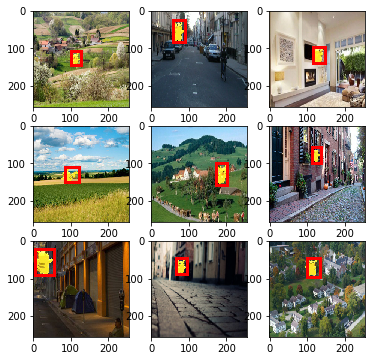

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

def box_to_rect(box, color, linewidth = 3):
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1],
        fill = False, edgecolor = color, linewidth = linewidth
    )

_, figs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        img = nd.transpose(img, (1,2,0)) + rgb_mean
        img = img.clip(0, 255).asnumpy() / 255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            # print(label)
            rect = box_to_rect(label[1:5]*data_shape, 'red')
            fig.add_patch(rect)
        #fig.axes.get_xaxis().set_visible(False)
        #fig.axes.get_yaxis().set_visible(False)
plt.show()

In [5]:
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

n = 40
x = nd.random.uniform(shape=(1,3,n,n))

y = MultiBoxPrior(x, sizes=[0.5, 0.25, 0.1], ratios=[1, 2, 0.5])

boxes = y.reshape((n,n,-1,4))
print(boxes.shape)
boxes[20, 20, :, :].shape[0]

(40, 40, 5, 4)


5

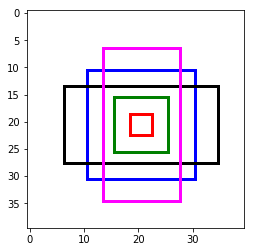

In [6]:
colors = ['blue', 'green', 'red', 'black', 'magenta']

plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i, :]*n, colors[i]))
plt.show()

### 预测物体类别

In [12]:
from mxnet.gluon import nn
# num_anchors 代表锚框数量
def class_predictor(num_anchors, num_classes):
    return nn.Conv2D(channels=num_anchors * (num_classes + 1), kernel_size=3, strides=1, padding=1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
print(cls_pred)
x = nd.zeros(shape=(2, 3, 20, 20))
y = cls_pred(x)
print(y.shape)

Conv2D(55, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(2, 55, 20, 20)


### 预测边界框

In [13]:
# 锚框数量*4，代表边界框
def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = box_pred(x)
y.shape

(2, 40, 20, 20)

### 减半模块

In [14]:
# num_filters 代表 channel 数量， 主要作用是做池化
def down_sample(num_filters):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(
            nn.Conv2D(num_filters, 3, strides=1, padding=1),
            nn.BatchNorm(in_channels=num_filters),
            nn.Activation('relu')
        )
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(20)
blk.initialize()

x = nd.zeros(shape=(2,3,20,20))
y = blk(x)
y.shape

(2, 20, 10, 10)

### 这里主要是一个空间金字塔池化的思想（或者说类似）

In [18]:
x = nd.zeros(shape=(2, 8, 20 ,20))
print(x.shape)

cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(x)
print("预测类别",y1.shape)

ds = down_sample(16)
ds.initialize()
x = ds(x)
print("减半处理",x.shape)

cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(x)
print("预测类别2",y2.shape)

(2, 8, 20, 20)
预测类别 (2, 55, 20, 20)
减半处理 (2, 16, 10, 10)
预测类别2 (2, 33, 10, 10)


In [47]:
def flatten_prediction(pred):
    # flatten 转换为2D的数组
    return pred.transpose(axes=(0,2,3,1)).flatten()

#def concat_prediction(preds):
#    return nd.concat(*preds, dim=1)
def concat_prediction(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print(flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print(flat_y2.shape)
flat_y = concat_prediction([flat_y1, flat_y2])
print(flat_y.shape)

(2, 22000)
(2, 3300)
(2, 25300)


### 主体网络

In [20]:
def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()

x = nd.zeros(shape=(2, 3, 224, 224))
y = bnet(x)
print(y.shape)

(2, 64, 28, 28)


### 创建SSD模型

In [28]:
def ssd_model(num_anchors, num_classes):
    downsamplers = nn.Sequential()
    for _ in range(3):
        downsamplers.add(down_sample(128))
    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))
    
    model = nn.Sequential()
    model.add(body(), downsamplers, class_predictors, box_predictors)
    return model

In [29]:
ssd = ssd_model(10, 2)
print(ssd)

Sequential(
  (0): HybridSequential(
    (0): HybridSequential(
      (0): Conv2D(16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=16)
      (2): Activation(relu)
      (3): Conv2D(16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=16)
      (5): Activation(relu)
      (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    )
    (1): HybridSequential(
      (0): Conv2D(32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=32)
      (2): Activation(relu)
      (3): Conv2D(32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=32)
      (5): Activation(relu)
      (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil

### 计算预测

In [50]:
def ssd_forward(x, model, sizes, ratios, verbose = False):
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    x = body(x)
    for i in range(5):
        # 预测
        anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(flatten_prediction(class_predictors[i](x)))
        box_preds.append(flatten_prediction(box_predictors[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with', anchors[-1].shape[1], 'anchors')
        # 向下采样
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max',
                kernel = (x.shape[2], x.shape[3])
            )
    # print(anchors)
    # print(class_preds)
    return (
        concat_prediction(anchors),
        concat_prediction(class_preds),
        concat_prediction(box_preds)
    )

### 完整的模型

In [51]:
from mxnet import gluon
from mxnet.gluon import nn
class SSD(nn.Block):
    def __init__(self, num_classes, verbose = False, **kwargs):
        super(SSD, self).__init__(**kwargs)
        
        self.size = [[.2,.272], [.37,.447], [.54,.619], [.71,.79], [.88,.961]]
        self.ratio = [[1, 2, 0.5]] * 5
        self.num_classes = num_classes
        self.verbose = verbose
        num_anchors = len(self.size[0]) + len(self.ratio[0]) - 1 # 5+3-1
        with self.name_scope():
            self.model = ssd_model(num_anchors, num_classes)
    def forward(self, x):
        anchors, class_preds, box_preds = ssd_forward(x, self.model, self.size, self.ratio, self.verbose)
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes + 1))
        return anchors, class_preds, box_preds

In [57]:
net = SSD(2, verbose=True)
net.initialize()

x = batch.data[0][0:1]
print(x.shape)

anchors, class_preds, box_preds = net(x)
# 锚框总共包含4个点
print(anchors.shape)
# num_classes 为2，因此总共3类
print(class_preds.shape)
# 5444 * 4为21776
print(box_preds.shape)

(1, 3, 256, 256)
Predict scale 0 (1, 64, 32, 32) with 4096 anchors
Predict scale 1 (1, 128, 16, 16) with 1024 anchors
Predict scale 2 (1, 128, 8, 8) with 256 anchors
Predict scale 3 (1, 128, 4, 4) with 64 anchors
Predict scale 4 (1, 128, 1, 1) with 4 anchors
(1, 5444, 4)
(1, 5444, 3)
(1, 21776)


In [59]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(anchors, class_preds, labels):
    class_preds = class_preds.transpose(axes=(0, 2, 1))
    return MultiBoxTarget(anchors, labels, class_preds)

out = training_targets(anchors, class_preds, batch.label[0][0:1])
print(out)

[
[[ 0.  0.  0. ...,  0.  0.  0.]]
<NDArray 1x21776 @cpu(0)>, 
[[ 0.  0.  0. ...,  0.  0.  0.]]
<NDArray 1x21776 @cpu(0)>, 
[[ 0.  0.  0. ...,  0.  0.  0.]]
<NDArray 1x5444 @cpu(0)>]
